# Take-Home assignment implementation

...in Python of course =) 

First, let's review what we need (goal, output) and what we need (input):

* **Goal**: Find the pixel value of the 3 upper HU circles.
* **Input**: Center pixel coordinate. This can be the pixel determined from last week's assignment, or we can assume the image center as a reasonable surrogate (256, 256). As well we have two images to measure; the images are at different fields-of-view so we cannot simply use pixel distances. We must somehow correct for the field-of-view.
* **Output**: 3 float values corresponding to the 3 HU pixel values.

We import the tools we'll need for analysis:

In [65]:
%matplotlib inline

import math
from urllib.request import urlretrieve

import dicom
import matplotlib.pyplot as plt

Let's load our images

Image size (pixels): (512, 512)


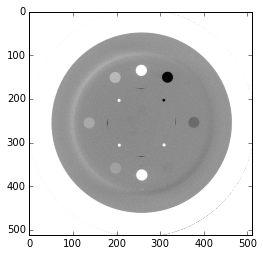

In [7]:
# download the files
small_FOV_file, _ = urlretrieve('https://github.com/jrkerns/MDA_workshop/blob/master/Data/CBCT.dcm?raw=true')
large_FOV_file, _ = urlretrieve('https://github.com/jrkerns/MDA_workshop/blob/master/Data/CBCT_small.dcm?raw=true')

# load them in as Python data structures
small_FOV_dcm = dicom.read_file(small_FOV_file)
large_FOV_dcm = dicom.read_file(large_FOV_file)

# we now have the entire DICOM dataset. The images are in the `pixel_array` property. We set them to variables for easier recall.
small_FOV_img = small_FOV_dcm.pixel_array
large_FOV_img = large_FOV_dcm.pixel_array

# let's make sure we have the right items.
print("Image size (pixels):", small_FOV_img.shape)
plt.imshow(small_FOV_img, cmap=plt.cm.Greys)  # cmap sets the colormap; in this case I want to turn it to greyscale

Okay, good. We have the images and DICOM data. We'll use the assumption that the center of the image is the center of the phantom (256, 256) since the image is 512, 512. **We want to find the physical distance from the center to the HU circles.** First, let's find how many pixels away they are, then convert that to real distance. Let's try to figure out the pixel distance for the central HU circle. We know the x-coordinate is 256, we just need the y-coordinate, so let's try plotting a dot until we get it.

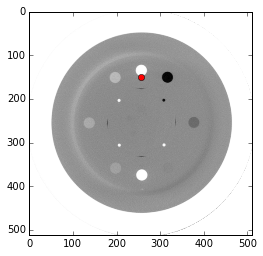

In [16]:
plt.imshow(small_FOV_img, cmap=plt.cm.Greys)
plt.plot(256, 150, 'ro', scalex=False, scaley=False)  # 150 is my initial guess for the HU circle. scalex/y keep the figure dimensions the same (0->512)

Close, but not quite. Let's try 134.

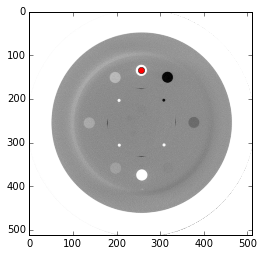

In [44]:
plt.imshow(small_FOV_img, cmap=plt.cm.Greys)
plt.plot(256, 134, 'ro', scalex=False, scaley=False)

That's pretty good. So we know the pixel distance is 256 - 134 = **122 pixels**. Note that this is only true for this image. The other image has a different pixel distance (but same physical distance).

Let's convert the pixel distance to real distance. Let's take a look at the DICOM tags for help.

In [18]:
small_FOV_dcm

(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20120626'
(0008, 0013) Instance Creation Time              TM: '184832'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.63.1.5401512045945835147.16659656049063764631
(0008, 0020) Study Date                          DA: '20120620'
(0008, 0021) Series Date                         DA: '20120626'
(0008, 0023) Content Date                        DA: '20120626'
(0008, 0030) Study Time                          TM: '124418'
(0008, 0031) Series Time                         TM: '184527.919'
(0008, 0033) Content Time                        TM: '184816.263'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'Varian Medical Systems'
(0008, 0090) Referring Physic

About 12 items from the bottom there is a ``Pixel Spacing`` tag. This is the pixel->mm conversion. I.e. each pixel is 0.488mm wide/long. Let's multiply this by our known pixel distance.

In [45]:
HU_real_distance = 122 * small_FOV_dcm.PixelSpacing[0] # There are two elements to the PixelSpacing tag (x, y), but they are the same value so I just grab the first one.
print("The distance from the center to the HU circles is {:.1f}mm".format(HU_real_distance))  # {:.1f} formats the value to be a float value showing 1 significant digit.

The distance from the center to the HU circles is 59.6mm


Okay, great. We know the physical distance from the center to the HU circles. This means we can determine how many pixels away the circles are no matter the field-of-view. We can simply invert the distance calculation (pixels = 59.6mm / spacing(px/mm)).

Let's see how far away the large field-of-view HU circles are this way.

The HU circles should be 67.8 pixels away


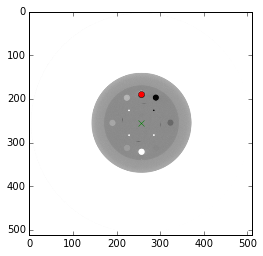

In [48]:
large_FOV_pixel_distance = HU_real_distance / large_FOV_dcm.PixelSpacing[0] 
print("The HU circles should be {:.1f} pixels away".format(large_FOV_pixel_distance))

# let's plot the large FOV image again to see if it's reasonable.
plt.imshow(large_FOV_img, cmap=plt.cm.Greys)
plt.plot(256, 256, 'gx', scalex=False, scaley=False)  # image/phantom center
plt.plot(256, 256-68, 'ro', scalex=False, scaley=False)  # HU location (rounded)

Awesome! We can determine the right distance to the HU circles for any field-of-view now. 

We also need to approximate the HU circle size. In the CatPhan 504 manual the size is not given explicitly, but can be approximated to be ~12mm (see page 9). To give us some wiggle room, let's just sample a 6mm size.

Now, ideally we would sample a circle, but that's a bit more complicated than sampling a square via indicies, so we'll just use the latter method for now.

Let's just prove we can sample a 6mm square from the small FOV image. We know the location of the center HU circle (256, 134).

In [52]:
# determine how many pixels 6mm is
six_mm_in_pixels = 6 / small_FOV_dcm.PixelSpacing[0]
round(six_mm_in_pixels)

12

So for the small FOV image we need a sample ROI of ~12 pixels on a side. We want to sample around the center pixel of the HU circle, so we'll sample from -6 to +6 pixels along both axes. In array indexing, the syntax goes [row, col], so we need [134+/-6, 256+/-6].

In [55]:
small_FOV_img[134-6:134+6, 256-6:256+6]

array([[ 1,  1,  1,  1,  1,  0,  0,  0,  0,  1,  1,  0],
       [12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  3],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  2],
       [ 3,  3,  2,  1,  2,  2,  2,  2,  2,  3,  3,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=uint16)

Okay, great. We've sampled the HU circle. Is it reasonable? On page 15 of the CatPhan manual the Air HU circle is said to be ~-1000 HU. Hmm, we're seeing ~0. Well, that's because DICOM raw images are stored in a format that compresses the available information with tags to reconstruct the values (this allows a wider range of values to be stored). Looking back at the DICOM tag list, near the bottom we see Rescale Intercept and Rescale Slope. These are what allows us to get the real HU values. Let's multiply the values by the correction tags.

In [57]:
HU_sample = small_FOV_img[134-6:134+6, 256-6:256+6] * small_FOV_dcm.RescaleSlope + small_FOV_dcm.RescaleIntercept
HU_sample

array([[ -999.,  -999.,  -999.,  -999.,  -999., -1000., -1000., -1000.,
        -1000.,  -999.,  -999., -1000.],
       [ -988., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
        -1000., -1000., -1000., -1000.],
       [ -998.,  -998.,  -997.,  -997.,  -997.,  -997.,  -997.,  -997.,
         -997.,  -996.,  -996.,  -997.],
       [ -999.,  -999., -1000., -1000., -1000., -1000., -1000., -1000.,
        -1000., -1000.,  -999.,  -998.],
       [-1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
        -1000., -1000., -1000., -1000.],
       [-1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
        -1000., -1000., -1000., -1000.],
       [ -996.,  -996.,  -996.,  -996.,  -996.,  -996.,  -996.,  -997.,
         -997.,  -997.,  -997.,  -998.],
       [ -997.,  -997.,  -998.,  -999.,  -998.,  -998.,  -998.,  -998.,
         -998.,  -997.,  -997.,  -997.],
       [-1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
        -1000., -1000., 

The average value is ~-1000, so we know we sampled the right area. You could also plot the edges of the box you intend to sample and see where it is on the image, as I did when finding the location of the HU circle.

Let's calculate the mean of the array to get the pixel value.

In [58]:
HU_sample.mean()

-999.09722222222217

We got our first HU value! Now, the next challenge is to figure out how to sample the other HU circles. We know the circles are the same distance from the center, but are at unknown angles. To generalize our solution (e.g. so we could find *all* the HU circle values) we can use a little trigonometry.

Because the circles on either side of the central one are the same value but opposite angle all we need to do is find one angle.
I'm going to use the same approach as for finding the initial HU cirlce and guess and plot. After a few guesses I landed on the following:

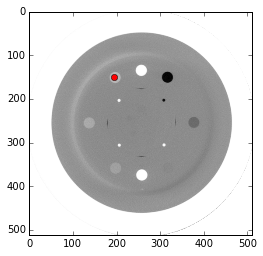

In [64]:
plt.imshow(small_FOV_img, cmap=plt.cm.Greys)
plt.plot(195, 150, 'ro', scalex=False, scaley=False)

From here, we can calculate the angle to the circle. Once known, we can simply use an angle to calculate other circles, rather than guessing an x/y position for each one.

We want to know the angle relative to straight up and down (our initial reference). To do so we recall SOH/CAH/TOA trig rules. We can find the opposite and adjacent, so let's do tan(x) = opposite/adjacent. Because straight up and down is 0, opposite becomes the x-distance and adjacent becomes the y-distance.

In [150]:
center_pixel = (256, 256)
angled_pixel = (195, 150)

opposite = center_pixel[0] - angled_pixel[0]
adjacent = center_pixel[1] - angled_pixel[1]

angle = math.atan(opposite/adjacent)  # in radians
angle = math.degrees(angle)  # in degrees
print("The left HU circle is {:.1f} degrees away".format(angle))

The left HU circle is 29.9 degrees away


Okay, so given this angle, we can now calculate both HU circles on either side (simply negate the value for opposite side).

Let's do this once manually and then we'll finish by making a function to do everything.

In [151]:
# calculate HU circle location based on center pixel, angle, and circle distance
center_pixel = (256, 256)
angle = 29.9
hu_distance = 59.6 # in mm
hu_dist_pix = hu_distance / small_FOV_dcm.PixelSpacing[0]  # in pixels

# for x-location, we use SOH -> opposite = sin(x) * hyp.
# then, make the shift relative to the center pixel location
x_shift = math.sin(math.radians(angle)) * hu_dist_pix
x_pos = center_pixel[0] - x_shift
print("X-position of left HU circle:", x_pos)

# CAH for y-location
y_shift = math.cos(math.radians(angle)) * hu_dist_pix
y_pos = center_pixel[1] - y_shift
print("Y-position of left HU circle:", y_pos)

X-position of left HU circle: 195.15418769545568
Y-position of left HU circle: 150.18588930752117


We've now confirmed the position of the left HU circle by way of angle calculation. All that's left is make a generic function to calculate all the HU values.

Before we start coding however, let's review our goal and I/O to determine what we need to pass into the function. We need to pass the image, DICOM tags, and center coordinates at least. To generalize the function, let's also pass in the angles the HU circles are at. In this way we can sample any and all of the circles. I don't want to pass all the tags individually, especially if I need to pass in more later for some reason, so let's instead go one level of abstraction up and pass the file and have the function open and get all the information we need.

Here's my pseudocode I wrote before writing the function:
    - Load the DICOM image & tags
    - For each HU circle/angle
        - Calculate central HU circle pixel
        - Sample the HU region of image array
        - Calculate mean
    - Return mean HU value of each HU circle

In [153]:
def sample_HU_regions(dcm_image_file, center_coords, angles):
    """A function that calculates the mean HU pixel values for a set of HU circles in a CBCT CatPhan 504 DICOM image. 
    Note that the DICOM image can have any field of view.
    
    Parameters
    ----------
    dcm_image_file : string
        A string pointing to a local DICOM file, e.g. 'path/to/my/file.dcm'.
    center_coords : tuple
        The central coordinates of the phantom, e.g. (100, 100).
    angles : sequence
        A list or sequence of the angles of the HU circles relative to the top-most HU circle.
        E.g. 0 gives the air circle, while -30 samples 30 degrees clockwise from the air circle, etc.
    """
    # uses of int(round(x)) are for converting values to integers, which are needed for indexing calls. 
    # E.g. we cannot call the 1.2th index of [0, 3, 5, 7].
    
    # known constants
    HU_DIST_MM = 59.6
    HU_CIRCLE_RADIUS_MM = 3  # 3mm on each side makes a 6mm sample region
    
    # Load the DICOM image & tags
    dcm_data = dicom.read_file(dcm_image_file)  # contains tags
    dcm_image = dcm_data.pixel_array
    hu_dist_pix = HU_DIST_MM / dcm_data.PixelSpacing[0]  # distance to HU circles in pixels
    hu_radius_pix = int(round(HU_CIRCLE_RADIUS_MM / dcm_data.PixelSpacing[0])) 
    
    # For each HU circle/angle
    hu_values = []  # list to keep all HU values in
    for angle in angles:
        
        # Calculate central HU circle pixel
        x_shift = math.sin(math.radians(angle)) * hu_dist_pix
        x_pos = int(round(center_coords[0] - x_shift))
        y_shift = math.cos(math.radians(angle)) * hu_dist_pix
        y_pos = int(round(center_coords[1] - y_shift))  # because in the y-direction 0 starts at the top we must subtract
        central_hu_pixel = (y_pos, x_pos)  # y comes first since indexing goes (row, col)
        
        # Sample the HU region of the image array
        cen_pix = central_hu_pixel  # for abbreviation, shorten the variable name
        hu_sample_array = dcm_image[cen_pix[0]-hu_radius_pix:cen_pix[0]+hu_radius_pix, cen_pix[1]-hu_radius_pix:cen_pix[1]+hu_radius_pix]
        
        # Calculate mean
        mean_hu_value = hu_sample_array.mean() * dcm_data.RescaleSlope + dcm_data.RescaleIntercept
        
        hu_values.append(mean_hu_value)
        
    # Return mean HU value of each HU circle
    return hu_values

Now that we have a function written up, let's test it out with just the center HU circle of the small FOV image since we know the HU value.

To quickly explain what we've passed for our first test:

- Recall the small FOV file was downloaded/defined near the top cell. 
- We assume 256, 256 as the center coordinates; we could use our own algorithm to calculate this as well. 
- We just pass in one angle for now to test it. 

In [146]:
sample_HU_regions(small_FOV_file, (256, 256), angles=[0,])

[-999.09722222222217]

Great, our function works. We know the center HU region is ~-1000 and that's what we get. Let's add in other angles.

In [147]:
sample_HU_regions(small_FOV_file, (256, 256), angles=[30, 0, -30])  # the top three circles

[-202.69444444444446, -999.09722222222217, 998.45138888888891]

Looking at the CatPhan 504 manual the top 3 circles, going clockwise, are PMP, Air, and Teflon, with nominal HU values of -200, -1000, and +1000. 

Let's see how the large FOV file does:


In [148]:
sample_HU_regions(large_FOV_file, (256, 256), angles=[30, 0, -30])

[-189.30555555555554, -997.0, 999.08333333333326]

These values are similar to the small FOV image. We've done it! We found the HU for the given circles. 
Because we generalized this by using the physical distance and not pixel distance we can calculate the HU values for any field of view. 

We can also analyze any/all HU circles by adding in the angles:

In [149]:
sample_HU_regions(large_FOV_file, (256, 256), angles=[90, 30, 0, -30, -90])

[-93.055555555555543,
 -189.30555555555554,
 -997.0,
 999.08333333333326,
 344.36111111111109]

And there we have it: a function that determines the HU pixel value for any HU circle in a CatPhan CBCT acquisition. You're well on your way to creating powerful software that rivals professional toolkits. Congratulations!